# Setup Forecasting Analysis

#### Matthew Fernadnez
##### 8/21/25
Data Creation, Data Cleaning, Feature Engineering, and Data Exploration all in this notebook. Data Creation is taken as a best estimator of the real-world data.

This projects goal is to forecast when a particular container needs to be serviced. 
<br>There are two ML models answering these questions:
<br>1. How many weeks out will a container need to be serviced?
<br>2. Will a container need to be serviced next week?


In [ ]:
import sys
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

import matplotlib.pyplot as plt

import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Shared/bin-cleaning-classifier")


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9a89ab8ae0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/3998080441746146', creation_time=1756144596362, experiment_id='3998080441746146', last_update_time=1756162822545, lifecycle_stage='active', name='/Shared/bin-cleaning-classifier', tags={'mlflow.experiment.sourceName': '/Shared/bin-cleaning-classifier',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'matthew98fernandez@gmail.com',
 'mlflow.ownerId': '74222388284847'}>

In [ ]:
np.random.seed(42)

## Data Creation
Create synthetic dates for every 7th day across 7 years

In [ ]:
## Create Synthetic dates
years = 7
start_date = datetime.now() - timedelta(days=years*365)

end_date = datetime.now()
num_dates = 52 * years
weeks = np.arange(1, num_dates + 1)

random_dates = [start_date + timedelta(weeks=i, days=np.random.randint(0, 7)) for i in range(num_dates)]
display(pd.DataFrame({'random_date': random_dates}))

random_date 2018-09-03T00:30:29.362Z 2018-09-07T00:30:29.362Z 2018-09-15T00:30:29.362Z 2018-09-24T00:30:29.362Z 2018-09-27T00:30:29.362Z 2018-10-06T00:30:29.362Z 2018-10-13T00:30:29.362Z 2018-10-22T00:30:29.362Z 2018-10-24T00:30:29.362Z 2018-11-01T00:30:29.362Z 2018-11-12T00:30:29.362Z 2018-11-15T00:30:29.362Z 2018-11-22T00:30:29.362Z 2018-12-01T00:30:29.362Z 2018-12-07T00:30:29.362Z 2018-12-13T00:30:29.362Z 2018-12-23T00:30:29.362Z 2018-12-29T00:30:29.362Z 2019-01-02T00:30:29.362Z 2019-01-11T00:30:29.362Z 2019-01-20T00:30:29.362Z 2019-01-27T00:30:29.362Z 2019-01-30T00:30:29.362Z 2019-02-08T00:30:29.362Z 2019-02-16T00:30:29.362Z 2019-02-19T00:30:29.362Z 2019-03-01T00:30:29.362Z 2019-03-06T00:30:29.362Z 2019-03-17T00:30:29.362Z 2019-03-23T00:30:29.362Z 2019-03-29T00:30:29.362Z 2019-04-02T00:30:29.362Z 2019-04-09T00:30:29.362Z 2019-04-18T00:30:29.362Z 2019-04-25T00:30:29.362Z 2019-05-06T00:30:29.362Z 2019-05-08T00:30:29.362Z 2019-05-17T00:30:29.362Z 2019-05-24T00:30:29.362Z 2019-06-03T00:30:29.362Z 2019-06-09T00:30:29.362Z 2019-06-16T00:30:29.362Z 2019-06-24T00:30:29.362Z 2019-06-30T00:30:29.362Z 2019-07-04T00:30:29.362Z 2019-07-12T00:30:29.362Z 2019-07-22T00:30:29.362Z 2019-07-26T00:30:29.362Z 2019-07-30T00:30:29.362Z 2019-08-08T00:30:29.362Z 2019-08-17T00:30:29.362Z 2019-08-22T00:30:29.362Z 2019-09-02T00:30:29.362Z 2019-09-07T00:30:29.362Z 2019-09-10T00:30:29.362Z 2019-09-23T00:30:29.362Z 2019-09-25T00:30:29.362Z 2019-10-04T00:30:29.362Z 2019-10-08T00:30:29.362Z 2019-10-18T00:30:29.362Z 2019-10-27T00:30:29.362Z 2019-10-30T00:30:29.362Z 2019-11-06T00:30:29.362Z 2019-11-12T00:30:29.362Z 2019-11-20T00:30:29.362Z 2019-11-30T00:30:29.362Z 2019-12-04T00:30:29.362Z 2019-12-13T00:30:29.362Z 2019-12-20T00:30:29.362Z 2019-12-30T00:30:29.362Z 2020-01-03T00:30:29.362Z 2020-01-13T00:30:29.362Z 2020-01-17T00:30:29.362Z 2020-01-25T00:30:29.362Z 2020-02-03T00:30:29.362Z 2020-02-06T00:30:29.362Z 2020-02-16T00:30:29.362Z 2020-02-18T00:30:29.362Z 2020-02-28T00:30:29.362Z 2020-03-04T00:30:29.362Z 2020-03-13T00:30:29.362Z 2020-03-18T00:30:29.362Z 2020-03-29T00:30:29.362Z 2020-04-05T00:30:29.362Z 2020-04-12T00:30:29.362Z 2020-04-15T00:30:29.362Z 2020-04-24T00:30:29.362Z 2020-05-03T00:30:29.362Z 2020-05-09T00:30:29.362Z 2020-05-18T00:30:29.362Z 2020-05-20T00:30:29.362Z 2020-05-27T00:30:29.362Z 2020-06-05T00:30:29.362Z 2020-06-10T00:30:29.362Z 2020-06-17T00:30:29.362Z 2020-06-28T00:30:29.362Z 2020-07-03T00:30:29.362Z 2020-07-12T00:30:29.362Z 2020-07-20T00:30:29.362Z 2020-07-27T00:30:29.362Z 2020-08-02T00:30:29.362Z 2020-08-10T00:30:29.362Z 2020-08-14T00:30:29.362Z 2020-08-18T00:30:29.362Z 2020-08-30T00:30:29.362Z 2020-09-05T00:30:29.362Z 2020-09-12T00:30:29.362Z 2020-09-16T00:30:29.362Z 2020-09-28T00:30:29.362Z 2020-10-03T00:30:29.362Z 2020-10-07T00:30:29.362Z 2020-10-13T00:30:29.362Z 2020-10-23T00:30:29.362Z 2020-10-30T00:30:29.362Z 2020-11-06T00:30:29.362Z 2020-11-14T00:30:29.362Z 2020-11-17T00:30:29.362Z 2020-11-28T00:30:29.362Z 2020-12-07T00:30:29.362Z 2020-12-12T00:30:29.362Z 2020-12-15T00:30:29.362Z 2020-12-22T00:30:29.362Z 2021-01-04T00:30:29.362Z 2021-01-05T00:30:29.362Z 2021-01-12T00:30:29.362Z 2021-01-22T00:30:29.362Z 2021-02-01T00:30:29.362Z 2021-02-04T00:30:29.362Z 2021-02-11T00:30:29.362Z 2021-02-16T00:30:29.362Z 2021-02-25T00:30:29.362Z 2021-03-04T00:30:29.362Z 2021-03-09T00:30:29.362Z 2021-03-18T00:30:29.362Z 2021-03-27T00:30:29.362Z 2021-03-31T00:30:29.362Z 2021-04-12T00:30:29.362Z 2021-04-14T00:30:29.362Z 2021-04-20T00:30:29.362Z 2021-04-30T00:30:29.362Z 2021-05-10T00:30:29.362Z 2021-05-11T00:30:29.362Z 2021-05-21T00:30:29.362Z 2021-05-26T00:30:29.362Z 2021-06-01T00:30:29.362Z 2021-06-14T00:30:29.362Z 2021-06-21T00:30:29.362Z 2021-06-27T00:30:29.362Z 2021-07-03T00:30:29.362Z 2021-07-08T00:30:29.362Z 2021-07-16T00:30:29.362Z 2021-07-25T00:30:29.362Z 2021-07-29T00:30:29.362Z 2021-08-05T00:30:29.362Z 2021-08-10T00:30:29.362Z 2021-08-19T00:30:29.362Z 2021-08-28T00:30:29.362Z 2021-09-06T00:30:29.362Z 2021-09-12T00:30:29.362Z 2021-09-16T00

In [ ]:
container_types = ['S14A+', 'CT22', 'P32A+', 'R64', 'S22A+', 'P22', 'S32', 'P14', 'CT64', 'S32A+', 'P64']

Container class as a helper function to create mock real-world data for container types

In [ ]:

class Container():
    

    def __init__(self, container_type, max_reuses, base_rate, season_amp, jitter_max, spike_count, spike_min, spike_max):
        """
        ## DEFAULT knobs
        base_rate = 0.1            # baseline weekly fill increment (~20%)
        season_amp = 0.25            # seasonality effect on the increment
        jitter_max = 0.15            # up to +10% extra noise on the increment (never negative)
        spike_count = 12
        spike_min, spike_max = 0.30, 0.60
        """
        self.container_type = container_type
        self.rng = np.random.default_rng(7)
        self.n_weeks = 52 * years
        self.threshold = 0.80
        self.max_reuses = max_reuses
        self.base_rate = base_rate
        self.season_amp = season_amp
        self.jitter_max = jitter_max
        self.spike_count = spike_count
        self.spike_min = spike_min
        self.spike_max = spike_max


    
    def create_levels(self):
        """
        Create the Levels and Reuses synthetic data
        """

        weeks = np.arange(self.n_weeks)
        seasonal = 1.0 + self.season_amp * np.sin(2*np.pi*weeks/52.0)

        # raw (positive) increment proposal each week
        inc_raw = self.base_rate * seasonal * (1.0 + self.rng.uniform(0.0, self.jitter_max, size=self.n_weeks))


        levels = np.zeros(self.n_weeks, dtype=float)
        increments = np.zeros(self.n_weeks, dtype=float)
        cleaned = np.zeros(self.n_weeks, dtype=bool)

        fill = 0.0
        last_inc = 0.0         # ensures non-decreasing increments within a run
        reset_next = False

        for t in range(self.n_weeks):
            # apply reset (clean) at the start of the week if flagged
            if reset_next:
                fill = 0.0
                last_inc = 0.0     # restart monotonic sequence after a clean
                reset_next = False
                cleaned[t] = True

            # enforce non-decreasing increment
            inc = max(inc_raw[t], last_inc)


            # update and store
            fill = min(1.0, fill + inc)
            levels[t] = fill
            increments[t] = inc
            last_inc = inc

            # schedule cleaning next week if threshold reached
            if fill >= self.threshold:
                reset_next = True
            
        levels = np.round(levels, decimals=2)

        # Reuses each container has w/r to date
        reuses = np.zeros([levels.size])
        dead_container_bool = np.zeros([levels.size], dtype=bool)
        for idx,i in enumerate(reuses[1:]):
            if reuses[idx-1] >= self.max_reuses:
                dead_container_bool[idx] =  True
                reuses[idx] = np.nan
            elif levels[idx-1] >= self.threshold:
                if dead_container_bool[idx-1] != True:
                    dead_container_bool[idx] =  False
                    reuses[idx] = int(reuses[idx-1]+1)
            else:
                if dead_container_bool[idx-1] != True:
                    dead_container_bool[idx] = False
                    reuses[idx] = int(reuses[idx-1])
        return levels, reuses

Create the containers with some added randomness to best reflect mock real-world data. Store all containers in a pandas DataFrame. 

In [ ]:
# Init empty DF
df_original = pd.DataFrame({"date": random_dates})

# Save all containers objects
stored_containers_dict = {}

for loc in ['E.1.1','E.1.2', 'C.1.1', 'C.1.3']:
    for name in container_types:
        max_reuses = np.random.choice([15, 20, 25, 30])
        base_rate = np.random.choice([0.05, 0.1, 0.13, 0.15])
        season_amp = np.random.choice([0.2, 0.22, 0.24, 0.26])
        jitter_max = np.random.choice([0.11, 0.13, 0.15])
        spike_count = np.random.choice([5, 8, 9, 10, 12])
        spike_min = np.random.choice([0.26, 0.28, 0.3, 0.32])
        spike_max = np.random.choice([0.25, 0.3, 0.4, 0.55])
        container_name = f"{name}_{loc}"
        container_tmp = Container(container_name, max_reuses=max_reuses, base_rate=base_rate, season_amp=season_amp, jitter_max=jitter_max, spike_count=spike_count, spike_min=spike_min, spike_max=spike_max)

        stored_containers_dict[container_name] = container_tmp # Store the containers and its attributes for each type of container

        levels, reuses = container_tmp.create_levels()

        # Store the fill_level and reuses counts for each container in a pd.DataFrame
        df_original[f"{container_name}_fill_level"] = levels
        df_original[f"{container_name}_reuses"] = reuses


## Data Exploration

In [ ]:
df_original = df_original.iloc[:-1]
df_original.head()

date  ...  P64_C.1.3_reuses
0 2018-09-03 00:30:29.362663  ...               1.0
1 2018-09-07 00:30:29.362663  ...               1.0
2 2018-09-15 00:30:29.362663  ...               1.0
3 2018-09-24 00:30:29.362663  ...               1.0
4 2018-09-27 00:30:29.362663  ...               1.0

[5 rows x 89 columns]

In [ ]:
display(df_original)

date S14A+_E.1.1_fill_level S14A+_E.1.1_reuses CT22_E.1.1_fill_level CT22_E.1.1_reuses P32A+_E.1.1_fill_level P32A+_E.1.1_reuses R64_E.1.1_fill_level R64_E.1.1_reuses S22A+_E.1.1_fill_level S22A+_E.1.1_reuses P22_E.1.1_fill_level P22_E.1.1_reuses S32_E.1.1_fill_level S32_E.1.1_reuses P14_E.1.1_fill_level P14_E.1.1_reuses CT64_E.1.1_fill_level CT64_E.1.1_reuses S32A+_E.1.1_fill_level S32A+_E.1.1_reuses P64_E.1.1_fill_level P64_E.1.1_reuses S14A+_E.1.2_fill_level S14A+_E.1.2_reuses CT22_E.1.2_fill_level CT22_E.1.2_reuses P32A+_E.1.2_fill_level P32A+_E.1.2_reuses R64_E.1.2_fill_level R64_E.1.2_reuses S22A+_E.1.2_fill_level S22A+_E.1.2_reuses P22_E.1.2_fill_level P22_E.1.2_reuses S32_E.1.2_fill_level S32_E.1.2_reuses P14_E.1.2_fill_level P14_E.1.2_reuses CT64_E.1.2_fill_level CT64_E.1.2_reuses S32A+_E.1.2_fill_level S32A+_E.1.2_reuses P64_E.1.2_fill_level P64_E.1.2_reuses S14A+_C.1.1_fill_level S14A+_C.1.1_reuses CT22_C.1.1_fill_level CT22_C.1.1_reuses P32A+_C.1.1_fill_level P32A+_C.1.1_reuses R64_C.1.1_fill_level R64_C.1.1_reuses S22A+_C.1.1_fill_level S22A+_C.1.1_reuses P22_C.1.1_fill_level P22_C.1.1_reuses S32_C.1.1_fill_level S32_C.1.1_reuses P14_C.1.1_fill_level P14_C.1.1_reuses CT64_C.1.1_fill_level CT64_C.1.1_reuses S32A+_C.1.1_fill_level S32A+_C.1.1_reuses P64_C.1.1_fill_level P64_C.1.1_reuses S14A+_C.1.3_fill_level S14A+_C.1.3_reuses CT22_C.1.3_fill_level CT22_C.1.3_reuses P32A+_C.1.3_fill_level P32A+_C.1.3_reuses R64_C.1.3_fill_level R64_C.1.3_reuses S22A+_C.1.3_fill_level S22A+_C.1.3_reuses P22_C.1.3_fill_level P22_C.1.3_reuses S32_C.1.3_fill_level S32_C.1.3_reuses P14_C.1.3_fill_level P14_C.1.3_reuses CT64_C.1.3_fill_level CT64_C.1.3_reuses S32A+_C.1.3_fill_level S32A+_C.1.3_reuses P64_C.1.3_fill_level P64_C.1.3_reuses 2018-09-03T00:30:29.362Z 0.16 0.0 0.11 0.0 0.16 0.0 0.11 0.0 0.14 0.0 0.14 0.0 0.14 0.0 0.16 0.0 0.05 0.0 0.14 0.0 0.16 0.0 0.11 0.0 0.16 0.0 0.11 0.0 0.16 0.0 0.11 1.0 0.16 0.0 0.16 0.0 0.11 0.0 0.16 0.0 0.16 0.0 0.16 0.0 0.16 0.0 0.05 0.0 0.11 0.0 0.05 0.0 0.14 0.0 0.05 0.0 0.14 0.0 0.05 0.0 0.16 0.0 0.16 0.0 0.11 0.0 0.14 0.0 0.16 0.0 0.16 0.0 0.05 0.0 0.05 0.0 0.16 0.0 0.14 0.0 0.11 0.0 0.16 0.0 0.16 0.0 0.11 1.0 2018-09-07T00:30:29.362Z 0.33 0.0 0.23 0.0 0.34 0.0 0.22 0.0 0.29 0.0 0.29 0.0 0.29 0.0 0.33 0.0 0.11 0.0 0.29 0.0 0.33 0.0 0.22 0.0 0.34 0.0 0.22 0.0 0.33 0.0 0.22 1.0 0.33 0.0 0.33 0.0 0.22 0.0 0.33 0.0 0.33 0.0 0.34 0.0 0.33 0.0 0.11 0.0 0.22 0.0 0.11 0.0 0.29 0.0 0.11 0.0 0.29 0.0 0.11 0.0 0.33 0.0 0.33 0.0 0.22 0.0 0.29 0.0 0.34 0.0 0.33 0.0 0.11 0.0 0.11 0.0 0.33 0.0 0.29 0.0 0.22 0.0 0.33 0.0 0.33 0.0 0.22 1.0 2018-09-15T00:30:29.362Z 0.5 0.0 0.34 0.0 0.52 0.0 0.34 0.0 0.44 0.0 0.44 0.0 0.45 0.0 0.5 0.0 0.17 0.0 0.44 0.0 0.5 0.0 0.34 0.0 0.52 0.0 0.33 0.0 0.5 0.0 0.33 1.0 0.5 0.0 0.51 0.0 0.34 0.0 0.51 0.0 0.5 0.0 0.52 0.0 0.51 0.0 0.17 0.0 0.34 0.0 0.17 0.0 0.44 0.0 0.17 0.0 0.44 0.0 0.17 0.0 0.51 0.0 0.51 0.0 0.34 0.0 0.43 0.0 0.52 0.0 0.51 0.0 0.17 0.0 0.17 0.0 0.51 0.0 0.44 0.0 0.34 0.0 0.5 0.0 0.5 0.0 0.33 1.0 2018-09-24T00:30:29.362Z 0.67 0.0 0.46 0.0 0.7 0.0 0.45 0.0 0.59 0.0 0.59 0.0 0.6 0.0 0.67 0.0 0.22 0.0 0.59 0.0 0.67 0.0 0.46 0.0 0.69 0.0 0.45 0.0 0.67 0.0 0.45 1.0 0.67 0.0 0.68 0.0 0.45 0.0 0.68 0.0 0.67 0.0 0.69 0.0 0.68 0.0 0.23 0.0 0.45 0.0 0.23 0.0 0.59 0.0 0.23 0.0 0.59 0.0 0.22 0.0 0.68 0.0 0.68 0.0 0.45 0.0 0.58 0.0 0.7 0.0 0.68 0.0 0.23 0.0 0.23 0.0 0.68 0.0 0.58 0.0 0.45 0.0 0.67 0.0 0.68 0.0 0.45 1.0 2018-09-27T00:30:29.362Z 0.84 0.0 0.58 0.0 0.87 0.0 0.57 0.0 0.74 0.0 0.74 0.0 0.76 0.0 0.84 0.0 0.28 0.0 0.74 0.0 0.85 0.0 0.57 0.0 0.87 0.0 0.56 0.0 0.85 0.0 0.56 1.0 0.84 0.0 0.86 0.0 0.57 0.0 0.86 0.0 0.84 0.0 0.87 0.0 0.85 0.0 0.29 0.0 0.57 0.0 0.28 0.0 0.74 0.0 0.28 0.0 0.75 0.0 0.28 0.0 0.85 0.0 0.85 0.0 0.57 0.0 0.73 0.0 0.87 0.0 0.86 0.0 0.29 0.0 0.29 0.0 0.86 0.0 0.73 0.0 0.57 0.0 0.84 0.0 0.85 0.0 0.56 1.0 2018-10-06T00:30:29.362Z 0.18 1.0 0.7 0.0 0.19 1.0 0.7 0.0 0.91 0.0 0.9 0.0 0.93 0.0 0.18 1.0 0.34 0.0 0.9 0.0 0.19 1.0 0.7 0.0 0.19 1.0 0.69 0.0 0.1

Evaluate two containers fill_level across time.

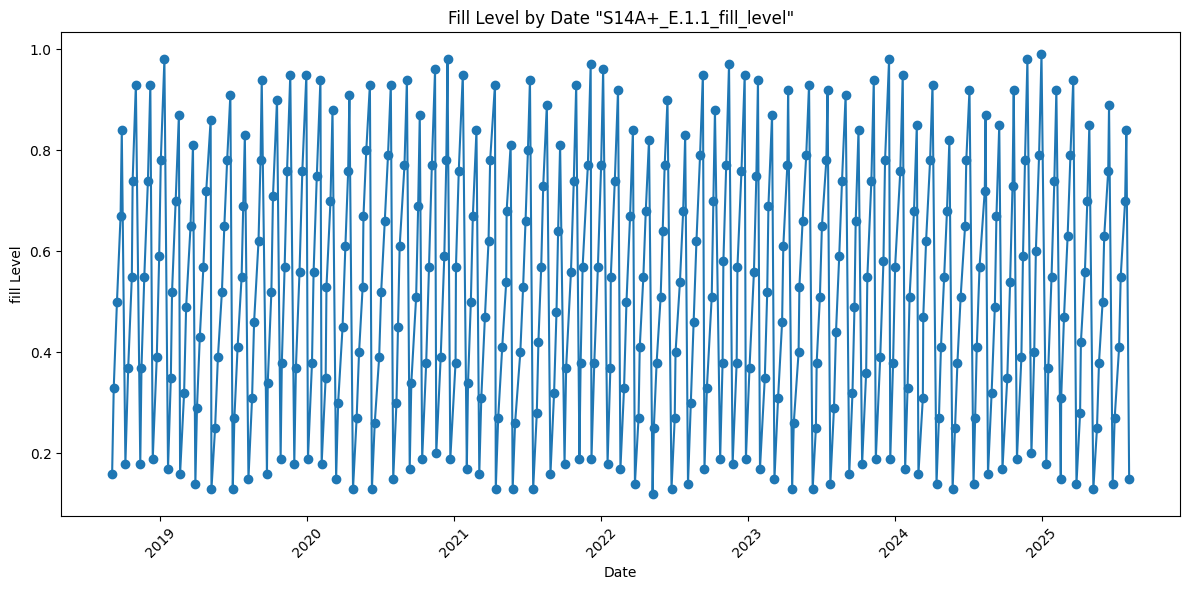

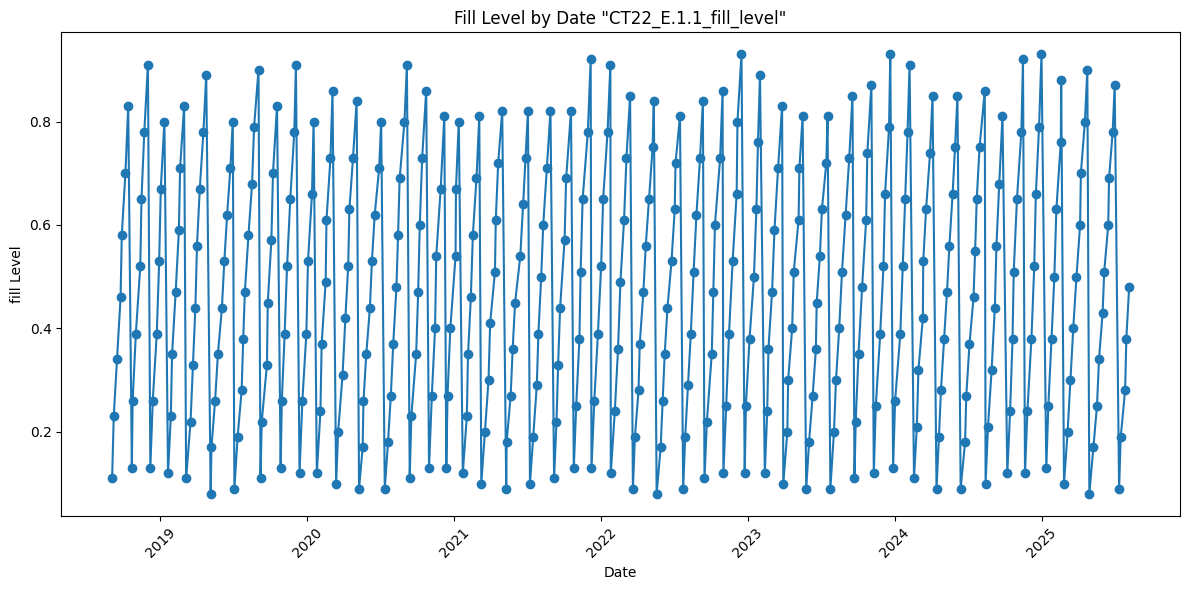

In [ ]:
counter = 0 
for name in list(df_original.columns):
    if "fill_level" in name: 

        plt.figure(figsize=(12, 6))
        plt.plot(df_original['date'], df_original[name], marker='o', linestyle='-')
        plt.title(f'Fill Level by Date "{name}"')
        plt.xlabel('Date')
        plt.ylabel('fill Level')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        plt.close()
        counter += 1
    if counter == 2: 
        break

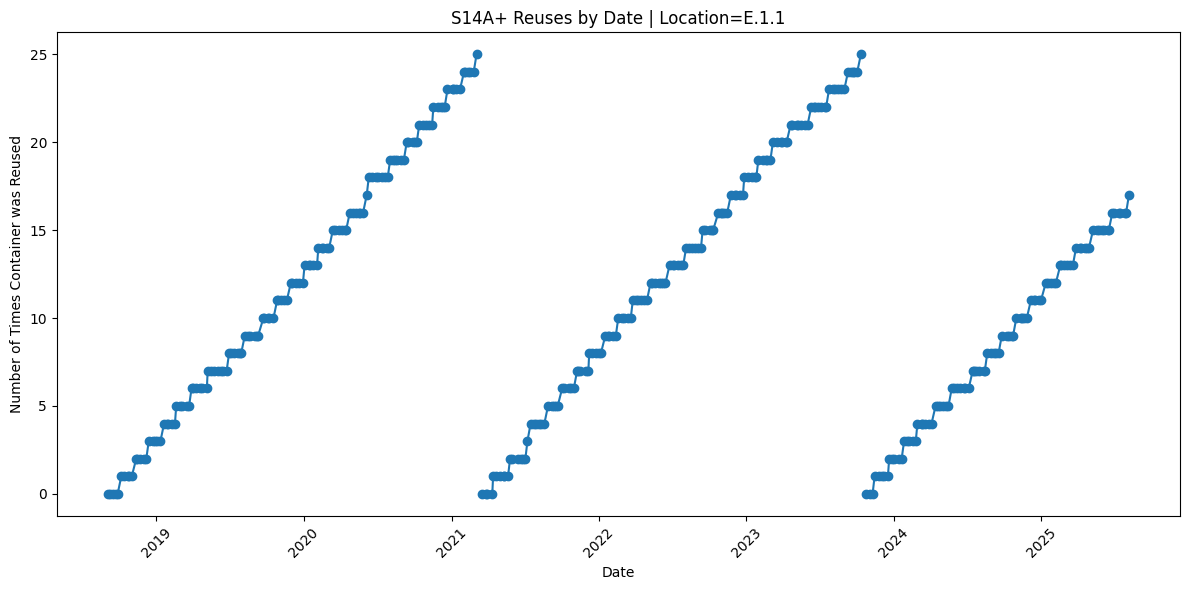

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_original['date'], df_original['S14A+_E.1.1_reuses'], marker='o', linestyle='-')
plt.title('S14A+ Reuses by Date | Location=E.1.1')
plt.xlabel('Date')
plt.ylabel('Number of Times Container was Reused')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let us now look at the spread each container and its associated location has been replaced due to reaching the max reusability. 

This will tell us the rate at which container and its associated location are serviced. 

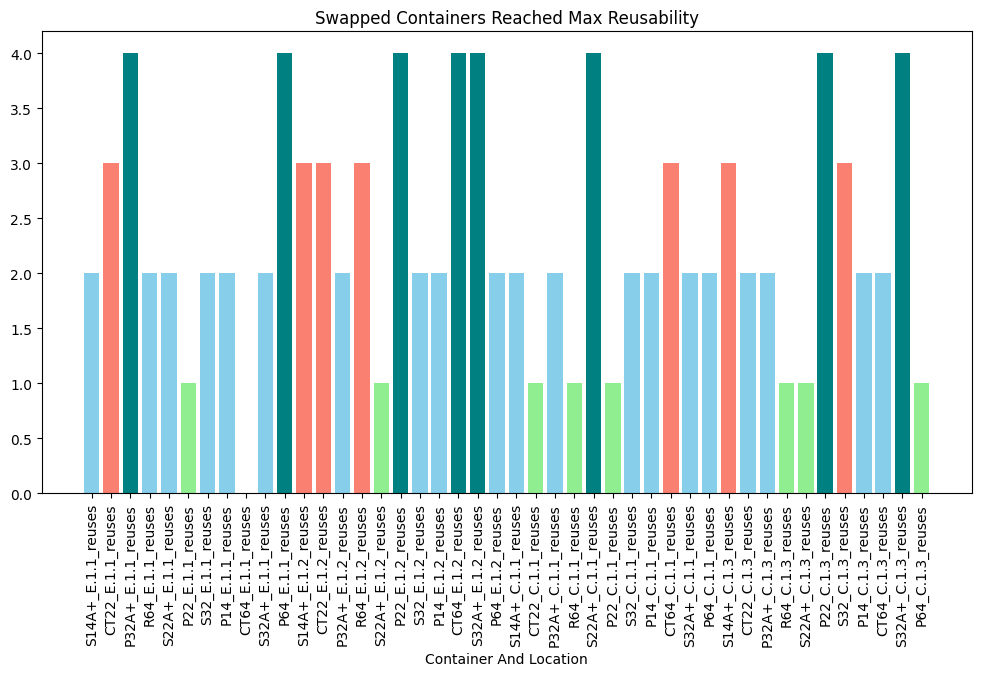

In [ ]:
reuses_cols = [name for name in list(df_original.columns) if "reuses" in name]
y = df_original[reuses_cols].isna().sum().values

colors = []
for val in y:
    if val == 4:
        colors.append('teal')
    elif val == 3:
        colors.append('salmon')
    elif val == 2:
        colors.append('skyblue')
    else:
        colors.append('lightgreen')

plt.figure(figsize=(12, 6))
plt.bar(reuses_cols, y, color=colors)
plt.xticks(rotation=90)
plt.title('Swapped Containers Reached Max Reusability')
plt.xlabel('Container And Location')
plt.show()

In [ ]:
df = df_original.copy()
print(df.shape)
df.head()

(363, 89)


date  ...  P64_C.1.3_reuses
0 2018-09-03 00:30:29.362663  ...               1.0
1 2018-09-07 00:30:29.362663  ...               1.0
2 2018-09-15 00:30:29.362663  ...               1.0
3 2018-09-24 00:30:29.362663  ...               1.0
4 2018-09-27 00:30:29.362663  ...               1.0

[5 rows x 89 columns]

# Data Preprocessing

In [ ]:
THRESHOLD = 0.80        # clean trigger
HORIZON_WEEKS = 2       # predict clean within next K weeks
LAGS = [1,2,3,4,5,6,7,8] # Fill levels from previous weeks
ROLLS = [3,6,12]         # Rolling window features over 3, 6, 12 weeks

df = df_original.copy()
df['date'] = pd.to_datetime(df['date'])

fill_cols = [c for c in df.columns if c.endswith('_fill_level')]
containers = [c.replace('_fill_level','') for c in fill_cols]

parts = []
for stem in containers:
    sub = df[['date', f'{stem}_fill_level', f'{stem}_reuses']].copy()
    sub.columns = ['date','fill_level','reuses']
    sub['container'] = stem
    parts.append(sub)

panel = (pd.concat(parts, ignore_index=True)
           .sort_values(['container','date'])
           .reset_index(drop=True))

def add_targets(g, horizon=HORIZON_WEEKS, threshold=THRESHOLD):
    g = g.sort_values('date').copy()
    # Rule: if fill >= threshold at t, a clean is *scheduled* at t+1
    g['should_clean_next_week'] = (g['fill_level'] >= threshold).astype(int)
    # Binary label: any clean in next K weeks?
    future = g.groupby(level=0, group_keys=False)
    g['clean_in_Kw'] = (g['should_clean_next_week']
                        .rolling(window=horizon, min_periods=1)
                        .max()
                        .shift(-1)  # look ahead from current week
                        .fillna(0)).astype(int)
    return g

panel = panel.groupby('container', group_keys=False).apply(add_targets)


In [ ]:

# --- detect realized clean events from generator's reuse bumps
def add_events(g: pd.DataFrame) -> pd.DataFrame:
    g = g.sort_values('date').reset_index(drop=True)
    g['clean_this_week'] = (g['reuses'].diff().fillna(0) > 0).astype(int)
    # fallback if NaNs in reuses: schedule clean next week if threshold crossed
    if g['reuses'].isna().any():
        fallback = (g['fill_level'] >= THRESHOLD).shift(1, fill_value=False).astype(int)
        g.loc[g['reuses'].isna(), 'clean_this_week'] = fallback[g['reuses'].isna()]
    # compute weeks-until-next-clean (first future index with clean_this_week==1)
    next_clean_idx = []
    weeks_until = []
    for i in range(len(g)):
        after = g.index[(g.index > i) & (g['clean_this_week'] == 1)]
        if len(after):
            j = int(after[0])
            next_clean_idx.append(j)
            weeks_until.append(j - i)
        else:
            next_clean_idx.append(np.nan)
            weeks_until.append(np.nan)
    g['next_clean_idx'] = next_clean_idx
    g['weeks_until_clean'] = weeks_until
    return g

panel = panel.groupby('container', group_keys=False).apply(add_events).reset_index(drop=True)

In [ ]:
def add_features(g):
    g = g.sort_values('date').copy()
    # time features
    g['weekofyear'] = g['date'].dt.isocalendar().week.astype(int)
    g['sin_woy'] = np.sin(2*np.pi*g['weekofyear']/52.0)
    g['cos_woy'] = np.cos(2*np.pi*g['weekofyear']/52.0)
    # lags & deltas
    for L in LAGS:
        g[f'lag_{L}'] = g['fill_level'].shift(L)
        g[f'delta_{L}'] = g['fill_level'] - g[f'lag_{L}']
    # rolling stats
    for W in ROLLS:
        g[f'roll_mean_{W}'] = g['fill_level'].rolling(W).mean()
        g[f'roll_std_{W}']  = g['fill_level'].rolling(W).std()
        g[f'roll_growth_{W}'] = g['fill_level'].diff().rolling(W).mean()
    # near threshold flag
    g['near_thresh'] = (g['fill_level'] >= 0.9*THRESHOLD).astype(int)
    # drop rows that would leak (need full history)
    feat_cols = [c for c in g.columns if c.startswith(('lag_','delta_','roll_'))] + \
                ['sin_woy','cos_woy','near_thresh','fill_level']
    g['features_ok'] = g[feat_cols].notna().all(axis=1)
    return g

panel = panel.groupby('container', group_keys=False).apply(add_features)



In [ ]:
ml_df = panel[panel['features_ok']].copy()

display(panel)

date fill_level reuses container should_clean_next_week clean_in_Kw clean_this_week next_clean_idx weeks_until_clean weekofyear sin_woy cos_woy lag_1 delta_1 lag_2 delta_2 lag_3 delta_3 lag_4 delta_4 lag_5 delta_5 lag_6 delta_6 lag_7 delta_7 lag_8 delta_8 roll_mean_3 roll_std_3 roll_growth_3 roll_mean_6 roll_std_6 roll_growth_6 roll_mean_12 roll_std_12 roll_growth_12 near_thresh features_ok 2018-09-03T00:30:29.362Z 0.05 0.0 CT22_C.1.1 0 0 0 13.0 13.0 36 -0.9350162426854147 -0.3546048870425359 null null null null null null null null null null null null null null null null null null null null null null null null null 0 false 2018-09-07T00:30:29.362Z 0.11 0.0 CT22_C.1.1 0 0 0 13.0 12.0 36 -0.9350162426854147 -0.3546048870425359 0.05 0.06 null null null null null null null null null null null null null null null null null null null null null null null 0 false 2018-09-15T00:30:29.362Z 0.17 0.0 CT22_C.1.1 0 0 0 13.0 11.0 37 -0.970941817426052 -0.23931566428755774 0.11 0.06000000000000001 0.05 0.12000000000000001 null null null null null null null null null null null null 0.11 0.060000000000000005 null null null null null null null 0 false 2018-09-24T00:30:29.362Z 0.23 0.0 CT22_C.1.1 0 0 0 13.0 10.0 39 -1.0 -1.8369701987210297E-16 0.17 0.06 0.11 0.12000000000000001 0.05 0.18 null null null null null null null null null null 0.17 0.060000000000000005 0.06 null null null null null null 0 false 2018-09-27T00:30:29.362Z 0.29 0.0 CT22_C.1.1 0 0 0 13.0 9.0 39 -1.0 -1.8369701987210297E-16 0.23 0.05999999999999997 0.17 0.11999999999999997 0.11 0.18 0.05 0.24 null null null null null null null null 0.23 0.05999999999999998 0.06 null null null null null null 0 false 2018-10-06T00:30:29.362Z 0.36 0.0 CT22_C.1.1 0 0 0 13.0 8.0 40 -0.992708874098054 0.1205366802553232 0.29 0.07 0.23 0.12999999999999998 0.17 0.18999999999999997 0.11 0.25 0.05 0.31 null null null null null null 0.29333333333333333 0.06506407098647708 0.06333333333333332 0.20166666666666666 0.11496376240653688 null null null null 0 false 2018-10-13T00:30:29.362Z 0.42 0.0 CT22_C.1.1 0 0 0 13.0 7.0 41 -0.9709418174260521 0.23931566428755738 0.36 0.06 0.29 0.13 0.23 0.18999999999999997 0.17 0.24999999999999997 0.11 0.31 0.05 0.37 null null null null 0.3566666666666667 0.06506407098647707 0.06333333333333332 0.2633333333333333 0.11656185768366367 0.06166666666666667 null null null 0 false 2018-10-22T00:30:29.362Z 0.49 0.0 CT22_C.1.1 0 0 0 13.0 6.0 43 -0.8854560256532101 0.464723172043768 0.42 0.07 0.36 0.13 0.29 0.2 0.23 0.26 0.17 0.31999999999999995 0.11 0.38 0.05 0.44 null null 0.42333333333333334 0.06506407098647703 0.06666666666666667 0.32666666666666666 0.11977757163453709 0.06333333333333334 null null null 0 false 2018-10-24T00:30:29.362Z 0.56 0.0 CT22_C.1.1 0 0 0 13.0 5.0 43 -0.8854560256532101 0.464723172043768 0.49 0.07000000000000006 0.42 0.14000000000000007 0.36 0.20000000000000007 0.29 0.2700000000000001 0.23 0.33000000000000007 0.17 0.39 0.11 0.45000000000000007 0.05 0.51 0.49000000000000005 0.06999999999999991 0.0666666666666667 0.3916666666666666 0.12351787994726378 0.06500000000000002 null null null 0 false 2018-11-01T00:30:29.362Z 0.62 0.0 CT22_C.1.1 0 0 0 13.0 4.0 44 -0.822983865893657 0.5680647467311548 0.56 0.05999999999999994 0.49 0.13 0.42 0.2 0.36 0.26 0.29 0.33 0.23 0.39 0.17 0.44999999999999996 0.11 0.51 0.5566666666666668 0.06506407098647689 0.06666666666666667 0.4566666666666666 0.12404300329590005 0.065 null null null 0 false 2018-11-12T00:30:29.362Z 0.69 0.0 CT22_C.1.1 0 0 0 13.0 3.0 46 -0.6631226582407955 0.7485107481711007 0.62 0.06999999999999995 0.56 0.1299999999999999 0.49 0.19999999999999996 0.42 0.26999999999999996 0.36 0.32999999999999996 0.29 0.39999999999999997 0.23 0.45999999999999996 0.17 0.5199999999999999 0.6233333333333334 0.06506407098647675 0.06666666666666665 0.5233333333333333 0.12404300329590003 0.06666666666666667 null null null 0 false 2018-11-15T00:30:29.362Z 0.76 0.0 CT22_C.1.1 0 1 0 13.0 2.0 46 -0.6631226582407955 0.7485107481711007 

In [ ]:
# suppose ml_df are pandas
ml_sdf          = spark.createDataFrame(ml_df)          # features + label for classifier


In [ ]:
catalog = "workspace"          # or your UC catalog
schema  = "ml"            # create if needed: spark.sql("CREATE SCHEMA IF NOT EXISTS main.ml")
spark.sql(
  f"CREATE SCHEMA IF NOT EXISTS {catalog}.{schema}"
)

ml_table      = f"{catalog}.{schema}.bin_cleaning_ml"

(ml_sdf
  .write
  .format("delta")
  .mode("overwrite")
  .option("overwriteSchema", "true")
  .saveAsTable(ml_table))


In [ ]:
v = spark.sql(f"DESCRIBE HISTORY {ml_table}").toPandas().iloc[0]['version']
print("Delta version saved:", v)


Delta version saved: 9
